In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.layouts import row, column
from bokeh.plotting import show, figure
from bokeh.models import ColumnDataSource, Slider

output_notebook()

Loading BokehJS ...

In [2]:
# read inputs to and outputs of R1s
retin_data = np.array(h5py.File('./retlam_demo/retina_input.h5','r')['photon']['data'])
retin_uids = np.array(h5py.File('./retlam_demo/retina_input.h5','r')['photon']['uids'])
retin_data = np.maximum(retin_data, 0)

retout_data = np.array(h5py.File('./retlam_demo/retina_output0.h5','r')['V']['data'])
retout_uids = np.array(h5py.File('./retlam_demo/retina_output0.h5','r')['V']['uids'])

In [3]:
lamout_filename = './retlam_demo/lamina_output0.h5'
lamout_h5 = h5py.File(lamout_filename,'r')
lamout_data = np.array(lamout_h5['V']['data'])
lamout_uids = np.array(lamout_h5['V']['uids'])

In [4]:
L1_list = []
L2_list = []
Mi1_list = []
Tm1_list = []
for i in range(len(lamout_uids)):
    if lamout_uids[i].startswith(b"neuron_L1"):
        L1_list.append(i)
    if lamout_uids[i].startswith(b'neuron_L2'):
        L2_list.append(i)

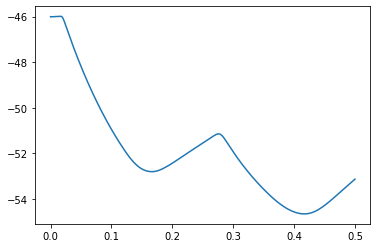

In [18]:
plt.plot(t, lamout_data[:,L1_list[0]])

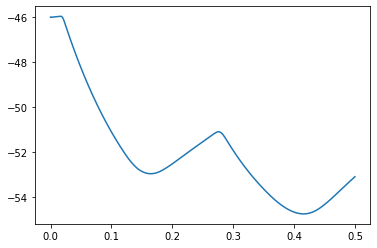

In [19]:
plt.plot(t, lamout_data[:,L2_list[0]])

In [5]:
dt = 1e-4
t = np.arange(0, 0.5, dt)

In [6]:
def synapse_step(t, V_pre, V_post, params=dict(g_sat=0.005, k=0.05, n=1, t_delay=1e-4, V_th=-50.5, V_rev=-80)):
    g_sat = params['g_sat']
    k = params['k']
    n = params['n']
    t_delay = params['t_delay']
    V_th = params['V_th']
    V_rev = params['V_rev']
    g = np.minimum(g_sat, k*np.maximum((V_pre*(t-t_delay)-V_th)**n, 0))
    I_syn = g*(V_post - V_rev)
    
    return I_syn

In [7]:
def ml_step(I_syn, V, N, dt, params=dict(V_1=-20.0, V_2=50.0, V_3=-40.0, V_4=20.0, phi=0.004)):
    V_1 = params['V_1']
    V_2 = params['V_2']
    V_3 = params['V_3']
    V_4 = params['V_4']
    phi = params['phi']
    E_L = -40.0
    E_Ca = 120.0
    E_K = -80.0

    g_L = 3.0
    g_Ca = 4.0
    g_K = 16.0
    dV = -I_syn - g_L*(V-E_L) - 0.5*g_Ca*(1+np.tanh((V-V_1)/V_2))*(V-E_Ca) - g_K*N*(V-E_K)
    dN = (0.5*(1+np.tanh((V-V_3)/V_4))-N)*(phi*np.cosh((V-V_3)/(2*V_4)))

    V1 = V + dV*dt
    N1 = N + dN*dt
    return [V1, N1]

In [16]:
def bkapp(doc):
    V_init = -46.0
    N_init = 0.35
    V = np.zeros_like(t)
    V[0] = V_init
    I_syn = np.zeros_like(t)
    N = np.zeros_like(t)
    N[0] = N_init
    V_post = np.zeros_like(t)
    
    for i in range(len(t)):
        V_pre = lamout_data[i,L1_list[0]]
        V_post = V[i]
        I_syn[i] = synapse_step(t[i], V_pre, V_post)
        V_pre, _ = ml_step(I_syn[i], V[i], N[i], dt)
        if i < len(t)-1:
            V[i+1] = V_pre
        
    source = ColumnDataSource(data=dict(t=t,V=V, I_syn=I_syn))
    p = figure(width=400, height=300)
    p.line('t', 'V', source=source)
    p.line('t', 'I_syn', source=source, line_color='orange')
#     p.line(t, lamout_data[:,L1_list[0]], line_color='grey')
    
    g_slider = Slider(value=0.001, start=0.001, end=1.0, step=0.001, title='g_sat')
    k_slider = Slider(value=0.001, start=0.001, end=1.0, step=0.001, title='k')
    n_slider = Slider(value=1, start=1, end=10, step=1, title='n')
    th_slider = Slider(value=-100.0, start=-100.0, end=0.0, step=0.5, title='V_th')
    rev_slider = Slider(value=-100.0, start=-100.0, end=0.0, step=0.5, title='V_rev')
    
    def update(attrname, old, new):
        g_sat = g_slider.value
        k = k_slider.value
        n = n_slider.value
        V_th = th_slider.value
        V_rev = rev_slider.value
        
        params=dict(g_sat=g_sat, k=k, n=n, t_delay=1e-4, V_th=V_th, V_rev=V_rev)
        
        V = np.zeros_like(t)
        V[0] = V_init
        I_syn = np.zeros_like(t)
        N = np.zeros_like(t)
        N[0] = N_init
        V_post = np.zeros_like(t)
        
        for i in range(len(t)):
            V_pre = lamout_data[i,L1_list[0]]
            V_post = V[i]
            I_syn[i] = synapse_step(t[i], V_pre, V_post, params=params)
            V_pre, _ = ml_step(I_syn[i], V[i], N[i], dt)
            if i < len(t)-1:
                V[i+1] = V_pre
                
        source.data = dict(t=t,V=V, I_syn=I_syn)
#         print(g_sat, k, n, V_th, V_rev)
                              
    for w in [g_slider, k_slider, n_slider, th_slider, rev_slider]:
        w.on_change('value_throttled', update)
                              
    inputs = column(g_slider, k_slider, n_slider, th_slider, rev_slider)
    
    doc.add_root(row(inputs, p))

In [17]:
show(bkapp, notebook_url="http://localhost:8888")